<a href="https://colab.research.google.com/github/vinayprabhu/Fun_random/blob/master/ImageNet_glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal: This scratchpad notebook was part of my tutorial to Chris et al with regarsd to the human-in-the-loop aided 300-D Glove embeddings for the imagenet classes.


In [1]:
!pip install mxnet
!pip install gluonnlp

In [0]:
import warnings
warnings.filterwarnings('ignore')

from mxnet import gluon
from mxnet import nd
import gluonnlp as nlp
import re
import json
import numpy as np
# from tdqm.notebook import tqdm

Helper functions:

In [3]:
import os
os.listdir('/content/sample_data/')

['README.md',
 'anscombe.json',
 'df_imagenet_glove.csv',
 '.ipynb_checkpoints',
 'california_housing_train.csv',
 'mnist_test.csv',
 'mnist_train_small.csv',
 'california_housing_test.csv']

In [0]:
emb = nlp.embedding.create('glove', source='glove.42B.300d')

In [5]:
import pandas as pd
df_imagenet_names=pd.read_csv('/content/sample_data/df_imagenet_glove.csv')
df_imagenet_names.head()

,class_number,label,wordnet_id
0,0,"tench, Tinca tinca",n01440764
1,1,"goldfish, Carassius auratus",n01443537
2,2,"great white shark, white shark, man-eater, man...",n01484850
3,3,"tiger shark, Galeocerdo cuvieri",n01491361
4,4,"hammerhead, hammerhead shark",n01494475


In [0]:
# ImageNet classes found here: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
# with open('/content/sample_data/imagenet1000_clsidx_to_labels.txt','r') as f:
#     imagenet_names = eval(f.read())
# imagenet_names

In [7]:
dict_imagenet=df_imagenet_names.loc[:,['class_number','label']].to_dict()
imagenet_names=dict_imagenet['label']
###########################################
counts = 0
n_classes = 1000
imagenet_glove = []
uniq = {}
missings = []
duplicates = []
for i in range(n_classes):
  imagenet_names[i] = imagenet_names[i].split(',')
  words = [w.lower() for w in imagenet_names[i][0].split()]
  vec = np.sum(emb[words], axis=0) / len(words)
  imagenet_glove.append(vec)
  if (np.sum(vec[:5]) != 0.0) and (str(vec) not in uniq):
      uniq[str(vec)] = words
      counts += 1
  elif np.sum(vec[:5]) == 0.0:
      print("Missing:", i,words)
      missings.append(i)
  else:
      print(f'Duplicate: {words} indexed {i}')
      print(i)
      duplicates.append(i)
        
print(f'Thus, we have covered {counts} classes')


Missing: 444 ['bicycle-built-for-two']
Duplicate: ['cardigan'] indexed 474
474
Missing: 607 ["jack-o'-lantern"]
Duplicate: ['maillot'] indexed 639
639
Thus, we have covered 996 classes


# Fixing the corner cases:

In [8]:
for i, lab in enumerate(df_imagenet_names.label.values):
    if('maillot' in lab.lower()):
      print(i,df_imagenet_names.iloc[i])
    elif('cardigan' in lab.lower()):
      print(i,df_imagenet_names.iloc[i])

264 class_number                               264
label           Cardigan, Cardigan Welsh corgi
wordnet_id                           n02113186
Name: 264, dtype: object
474 class_number          474
label            cardigan
wordnet_id      n02963159
Name: 474, dtype: object
638 class_number          638
label             maillot
wordnet_id      n03710637
Name: 638, dtype: object
639 class_number                   639
label           maillot, tank suit
wordnet_id               n03710721
Name: 639, dtype: object


OK. SO, let's fix these one by one:

Source: https://danceparent101.com/leotard-vs-unitard-whats-the-difference-why-do-dancers-need-both/
*Jules leotard wore a tight-fitting garment called a maillot, a name still used today to describe women’s bathing suits. But it wasn’t until after the death of Frenchman Jules Leotard (1838-1870) who designed for himself a skin-tight all in one maillot to wear during his acrobatic and gymnastic performances that the word leotard was used to describe the garment. Jules’ original leotard was in fact by today’s standards a unitard!*

Also, this [link](https://www.akc.org/dog-breeds/cardigan-welsh-corgi/) claims that the Cardigan springs from the same line of dogs as Dachshund.

OK, lets' substitute these manually.

In [0]:
# Missing

df_imagenet_names.loc[444,'label']='trikes'
df_imagenet_names.loc[607,'label']='lanterns'

# Duplicates: Cardigans

df_imagenet_names.loc[264,'label']='Corgi, dachshund'
df_imagenet_names.loc[474,'label']='tweed'

# Duplicates: Maillots

df_imagenet_names.loc[638,'label']='leotards'
df_imagenet_names.loc[639,'label']='unitards'

# Save: 
df_imagenet_names.to_csv('df_imagenet_renamed.csv',index=False)

In [10]:
# Re-run the classes:

dict_imagenet=df_imagenet_names.loc[:,['class_number','label']].to_dict()
imagenet_names=dict_imagenet['label']
###########################################
counts = 0
n_classes = 1000
imagenet_glove = []
uniq = {}
missings = []
duplicates = []
for i in range(n_classes):
  imagenet_names[i] = imagenet_names[i].split(',')
  words = [w.lower() for w in imagenet_names[i][0].split()]
  vec = np.sum(emb[words], axis=0) / len(words)
  imagenet_glove.append(vec)
  if (np.sum(vec[:5]) != 0.0) and (str(vec) not in uniq):
      uniq[str(vec)] = words
      counts += 1
  elif np.sum(vec[:5]) == 0.0:
      print("Missing:", i,words)
      missings.append(i)
  else:
      print(f'Duplicate: {words} indexed {i}')
      print(i)
      duplicates.append(i)
        
print(f'Thus, we have covered {counts} classes')


Thus, we have covered 1000 classes


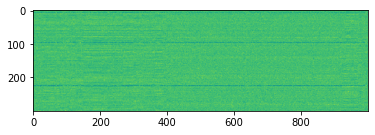

In [11]:
# import tqdm.notebook as tqdm
def versor(p_0):
    return  p_0/np.linalg.norm(p_0)
imagenet_glove_300=np.zeros((1000,300))
for i in range(1000):
  imagenet_glove_300[i,:]=versor(imagenet_glove[i].asnumpy())
import matplotlib.pyplot as plt
plt.imshow(imagenet_glove_300.T)

In [0]:
from umap import UMAP
projector = UMAP()
embeddings_projected = projector.fit_transform(imagenet_glove_300)

In [13]:
df_imagenet_names.head()

,class_number,label,wordnet_id
0,0,"tench, Tinca tinca",n01440764
1,1,"goldfish, Carassius auratus",n01443537
2,2,"great white shark, white shark, man-eater, man...",n01484850
3,3,"tiger shark, Galeocerdo cuvieri",n01491361
4,4,"hammerhead, hammerhead shark",n01494475


In [0]:
# Save the files!
# 1: The dataframe
df_imagenet_names['umap_x']=embeddings_projected[:,0] 
df_imagenet_names['umap_y']=embeddings_projected[:,1]
df_imagenet_names.to_csv('df_imagenet_names_umap.csv',index=False)
# 2: The numpy tensors
np.save('imagenet_glove_300_umap.npy',embeddings_projected)
np.save('imagenet_glove_300.npy',imagenet_glove_300)

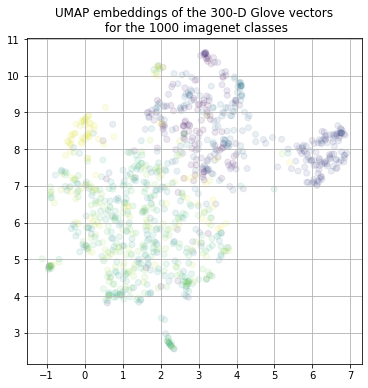

In [15]:
plt.figure(figsize=(6,6))
plt.scatter(embeddings_projected[:,0], embeddings_projected[:,1], c=df_imagenet_names.class_number.values, alpha=0.1)
plt.grid('On')
plt.title('UMAP embeddings of the 300-D Glove vectors\n for the 1000 imagenet classes')
plt.savefig('imagenet_umap_glove300.pdf',bbox_inches='tight')

In [0]:
from bokeh.palettes import plasma
from bokeh.plotting import ColumnDataSource,figure, show
from bokeh.io import output_notebook
# Call once to configure Bokeh to display plots inline in the notebook.
output_notebook()


def big_palette(size, palette_func):
    if size < 256:
        return palette_func(size)
    p = palette_func(256)
    out = []
    for i in range(size):
        idx = int(i * 256.0 / size)
        out.append(p[idx])
    return out
my_palette = big_palette(1000,plasma)

In [17]:
dict_source = ColumnDataSource(data=dict(
    x=embeddings_projected[:,0],
    y=embeddings_projected[:,1],
    c=my_palette,
    desc=list(df_imagenet_names.label.values),
    )
)
# ,color=df_imagenet_names.class_number,
TOOLTIPS = [
    ("index", "$index"),
    ("(x,y)", "($x, $y)"),
    ("desc", "@desc"),
]

p = figure(plot_width=600, plot_height=600, tooltips=TOOLTIPS,
           title="ImageNet classes (Semantic clustering) ",background_fill_color='white')

p.circle('x', 'y', size=5,color='c',fill_color="c", source=dict_source)

show(p)

# @ Chris: If you don't like the puritanical assignments, pick 2 NN classes and find the angular mean of the glove vectors:
```
def versor(p_0):
    return  p_0/np.linalg.norm(p_0)

def slerp_vec(p_0,p_1,t):
    """
    Friends don't let friends linearly interpolation in high dimensions
    """    
    p_0=versor(p_0)
    p_1=versor(p_1)
    
    Omega=np.arccos(np.dot(p_0,p_1))
    if(np.isclose(np.rad2deg(Omega),180,atol=1e-3)):
        print('180 degrees apart! Perturbing the first!')
        p_0=p_0+1e-3*np.random.randn(len(p_0))
        p_0=p_0/np.linalg.norm(p_0)
        print(p_0)
        Omega=np.arccos(np.dot(p_0,p_1))
    slerp_p0_p1_t= (np.sin( (1-t)* Omega)/np.sin( Omega))*p_0+ (np.sin(t* Omega)/ np.sin(Omega))*p_1
    
    return versor(slerp_p0_p1_t)
```